# Introduction

---

This notebook presents an implementation of an analysis method for detecting and understanding artefacts in NLP datasets, specifically the Stanford Natural Language Inference (SNLI) dataset. This analysis is based on the research paper titled **"Competency Problems: On Finding and Removing Artifacts in Language Data"**.

In NLP tasks, datasets often contain subtle biases or artefacts that models may exploit to make predictions. These biases aren't always evident upon cursory inspection and may lead to overestimated performance metrics as models rely on them rather than learning the intended linguistic phenomena.

The research paper this notebook refers to proposes a method for detecting these dataset artefacts using statistical techniques. **The approach is grounded on the calculation of Z-statistics for each token in the dataset, considering each label. A token with a Z-statistic that significantly deviates from what we would expect under a null hypothesis is considered a potential artefact.**

***This notebook covers the process of loading and preprocessing the dataset, calculating token statistics, and using these statistics to identify potential artefacts.*** It also provides a visualization of these artefacts, offering insights into how they distribute across different labels in the dataset.


---




# Install dependencies

In [1]:
%pip install datasets

You should consider upgrading via the '/Users/venkateshmurugadas/.pyenv/versions/3.10.0/envs/thesis/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Import

In [1]:
# Standard library imports
from collections import Counter, defaultdict
import string
from typing import List

# Third-party imports
from datasets import load_dataset
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import norm


/Users/venkateshmurugadas/.pyenv/versions/3.10.0/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and preprocess dataset

In [2]:
# load coliee dataset
data_path = "data/coliee_train/coliee_2021.csv"
coliee_train = pd.read_csv(data_path)

In [3]:
def preprocess(sentence: str) -> List[str]:
    """
    Function to preprocess a given sentence.

    Parameters:
    sentence (str): The sentence to be preprocessed.

    Returns:
    List[str]: List of tokens in the preprocessed sentence.
    """
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    sentence_no_punct = sentence.translate(translator)

    # Tokenize on whitespace
    tokens = sentence_no_punct.lower().split()

    return tokens

# Apply the preprocess function to the 'hypothesis' column of the DataFrame
# The result is a new column 'tokens' containing the tokenized hypothesis
coliee_train['tokens'] = coliee_train['hypothesis'].apply(preprocess)

In [4]:
coliee_train

,id,label,premise,hypothesis,tokens
0,H21-1-1,Y,Article 5\n(1) A minor must obtain the consent...,Acceptance made by a minor that received an of...,"[acceptance, made, by, a, minor, that, receive..."
1,H21-1-2,N,Article 6\n(1) A minor who is permitted to con...,"If a minor, after getting permission for carry...","[if, a, minor, after, getting, permission, for..."
2,H21-1-3,Y,Article 9\nA juridical act performed by an adu...,The purchase of daily household items may not ...,"[the, purchase, of, daily, household, items, m..."
3,H21-1-4,N,Article 13\n(1) A person under curatorship mus...,"If a person under curatorship performs, withou...","[if, a, person, under, curatorship, performs, ..."
4,H21-1-5,N,Article 7\nThe family court may decide to comm...,The person in question may not request a comm...,"[the, person, in, question, may, not, request,..."
...,...,...,...,...,...
800,H24-29-1,N,Article 712\nIf a minor has inflicted damage o...,A plaintiff shall prove that the opponent has ...,"[a, plaintiff, shall, prove, that, the, oppone..."
801,H24-29-3,N,Article 711\nA person that has taken the life ...,Parents of a person who died by a tort may cla...,"[parents, of, a, person, who, died, by, a, tor..."
802,H24-30-1,N,Article 452\nIf an obligee has requested perfo...,In cases where an obligee A demands performanc...,"[in, cases, where, an, obligee, a, demands, pe..."
803,H24-30-2,N,Article 633\nRemuneration must be paid simulta...,In the cases where delivery of the subject mat...,"[in, the, cases, where, delivery, of, the, sub..."


# Prepare Hypothesis Token statistics

In [5]:
# Get a list of unique labels in the dataset
labels = coliee_train['label'].unique().tolist()

In [6]:
# Initialize Counters
token_counts = Counter()

# token_label_counts is a defaultdict of Counters.
# For each label, it will hold a Counter that contains the count of each token for that label.
token_label_counts = defaultdict(Counter)

for i, row in coliee_train.iterrows():
    token_counts.update(row['tokens'])
    token_label_counts[row['label']].update(row['tokens'])

# Create a DataFrame for token statistics
token_df = pd.DataFrame.from_dict(token_counts, orient='index', columns=['total_count'])
token_df.index.name = 'token'
token_df.reset_index(inplace=True)

## Calculate Conditional Probabilities for label given token

In [7]:
# For each label, we add two new columns to the DataFrame:
# 1. A count column, which indicates how many times each token appears with that label
# 2. A probability column, which is the count for each token and label divided by the total count for that token

# Iterate over all unique labels
for label in labels:
    token_df[f'{label}_count'] = token_df['token'].map(token_label_counts[label])
    token_df[f'{label}_prob'] = token_df[f'{label}_count'] / token_df['total_count']


In [8]:
token_df

,token,total_count,Y_count,Y_prob,N_count,N_prob
0,acceptance,18,9,0.500000,9,0.500000
1,made,65,36,0.553846,29,0.446154
2,by,276,137,0.496377,139,0.503623
3,a,1491,775,0.519785,716,0.480215
4,minor,26,14,0.538462,12,0.461538
...,...,...,...,...,...,...
1990,charging,1,1,1.000000,0,0.000000
1991,opponent,1,0,0.000000,1,1.000000
1992,wrongdoer,1,0,0.000000,1,1.000000
1993,perfomance,1,0,0.000000,1,1.000000


## Calculate Z-Statistics for each token in each label

In [9]:
# Set the null hypothesis probability
# The null hypothesis in this context is that the labels are evenly distributed among the tokens.
# So, we calculate the probability under the null hypothesis (p0) by dividing 1 by the number of unique labels.
p0 = 1 / len(labels)

'''
Calculate the z-statistics for each label
The z-statistic is a measure of how much the observed probability deviates from the expected probability
under the null hypothesis.
A high absolute value of the z-statistic indicates that the observed probability
significantly deviates from the expected probability, which may suggest the presence of a bias or artifact.
We calculate the z-statistic for each label and add it as a new column in the DataFrame.
'''

# This specific z_stat is not used directly in the analysis (this is done only for reference and understanding)
for label in labels:
    token_df[f'{label}_z_stat'] = (token_df[f'{label}_prob'] - p0) / np.sqrt((p0 * (1 - p0)) / token_df['total_count'])


In [10]:
token_df

,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat
0,acceptance,18,9,0.500000,9,0.500000,0.000000,0.000000
1,made,65,36,0.553846,29,0.446154,0.868243,-0.868243
2,by,276,137,0.496377,139,0.503623,-0.120386,0.120386
3,a,1491,775,0.519785,716,0.480215,1.527964,-1.527964
4,minor,26,14,0.538462,12,0.461538,0.392232,-0.392232
...,...,...,...,...,...,...,...,...
1990,charging,1,1,1.000000,0,0.000000,1.000000,-1.000000
1991,opponent,1,0,0.000000,1,1.000000,-1.000000,1.000000
1992,wrongdoer,1,0,0.000000,1,1.000000,-1.000000,1.000000
1993,perfomance,1,0,0.000000,1,1.000000,-1.000000,1.000000


## Calculate the Threshold for rejecting null hypothesis

1. Choose a significance level. it's the maximum probability of making a Type I error (false positive) that we're willing to accept.
2. Calculate the number of tests (unique tokens in the DataFrame). We need this for the Bonferroni correction, which adjusts the significance level to control the family-wise error rate when performing multiple tests.
3. Apply the Bonferroni correction. The Bonferroni correction is a method used to counteract the problem of multiple comparisons.It adjusts the significance level by dividing it by the number of tests. This makes the significance threshold more stringent, reducing the probability of false positives.
4. Calculate the z-statistic threshold. The z-statistic threshold is the value that the z-statistic must exceed for us to reject the null hypothesis at the chosen significance level. It's calculated using the inverse of the cumulative distribution function (quantile function) of the standard normal distribution.
5. Calculate the overall threshold above which the null hypothesis can be rejected.Tokens with an observed probability greater than this threshold are considered significant at the chosen significance level. This line ensures the threshold is between 0 and 1 by applying the np.minimum and np.maximum functions.
6. Calculate the threshold for each token. This calculation is similar to the overall threshold calculation but it's done for each token individually.
The resulting 'threshold' column in the DataFrame gives the threshold for each token.

In [11]:
alpha = 0.01
num_tests = len(token_df)
alpha_bonferroni = alpha / num_tests

# Calculate the z-statistic threshold
z_alpha = norm.ppf(1 - alpha_bonferroni / 2)

# Calculate the overall threshold
threshold = np.minimum(1, np.maximum(0, p0 + z_alpha / (2 * np.sqrt(token_df['total_count'].sort_values()))))

# Calculate the threshold for each token
token_df['threshold'] = np.minimum(1, np.maximum(0, p0 + z_alpha / (2 * np.sqrt(token_df['total_count']))))

# token_df['threshold'] = p0 + z_alpha * np.sqrt((p0 * (1 - p0)) / token_df['total_count'])


In [12]:
token_df

,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold
0,acceptance,18,9,0.500000,9,0.500000,0.000000,0.000000,1.000000
1,made,65,36,0.553846,29,0.446154,0.868243,-0.868243,0.783064
2,by,276,137,0.496377,139,0.503623,-0.120386,0.120386,0.637368
3,a,1491,775,0.519785,716,0.480215,1.527964,-1.527964,0.559102
4,minor,26,14,0.538462,12,0.461538,0.392232,-0.392232,0.947563
...,...,...,...,...,...,...,...,...,...
1990,charging,1,1,1.000000,0,0.000000,1.000000,-1.000000,1.000000
1991,opponent,1,0,0.000000,1,1.000000,-1.000000,1.000000,1.000000
1992,wrongdoer,1,0,0.000000,1,1.000000,-1.000000,1.000000,1.000000
1993,perfomance,1,0,0.000000,1,1.000000,-1.000000,1.000000,1.000000


# Plot Interactive Artefacts map

In [14]:
# Create an interactive scatter plot using Plotly

# Define a new figure
fig = go.Figure()

# Define a dictionary of colors for each label
colors = {'Y': 'green', 'N': 'red', 'grey': 'grey'}

# Plot the observed probabilities for each token and label
for label in labels:
    # Get the DataFrame for the current label
    data_label = token_df

    # Determine which points are above the threshold
    # This creates a Boolean Series where each element is True if the observed probability is
    # above the threshold, and False otherwise
    is_above_threshold = data_label[f'{label}_prob'] > data_label['threshold']

    # Add scatter plots for points above and below the threshold
    # Points above the threshold are colored according to the label, and
    # points below the threshold are colored grey
    for condition, color in zip([is_above_threshold, ~is_above_threshold], [colors[label], 'grey']):
        token = data_label[condition]['token']
        text = [f"Label: {label}<br>Token: {t}" for t in token]
        fig.add_trace(go.Scatter(
            x = data_label[condition]['total_count'],
            y = data_label[condition][f'{label}_prob'],
            mode = 'markers',
            name = label if color != 'grey' else None,
            marker = dict(
                color = color,
                size = 4
            ),
            text = text,
            hovertemplate = "%{text}<br>Occurrences: %{x}<br>Observed probabilities: %{y}<extra></extra>"
        ))

# Add the threshold line to the plot
fig.add_trace(go.Scatter(
    x = token_df['total_count'].sort_values(),
    y = threshold,
    mode = 'lines',
    name = f'alpha=0.01/{num_tests}',
    line = dict(color='blue')
))

# Set the scale of the x-axis to logarithmic and limit its range
fig.update_xaxes(type='log', range=[1.3, np.log10(max(token_df['total_count']))])

# Set the labels for the x and y axes, and the title for the plot
fig.update_layout(
    xaxis_title='n',
    yaxis_title='p(y|x)',
    title='Artefacts in SNLI dataset'
)

# Display the plot
fig.show()


In [13]:
fig.write_html('snli_artefacts_interactive_chart.html')

# Plot Static Map

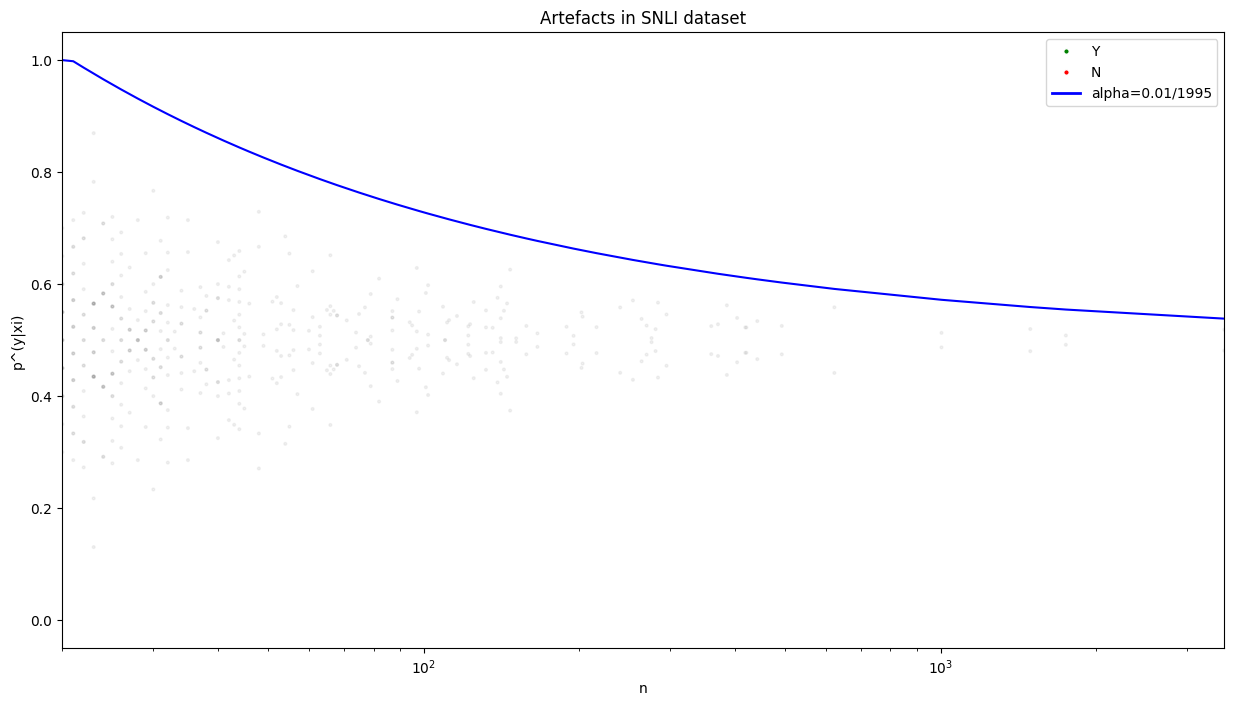

In [16]:
# Define the figure and axes for the plot
fig, ax = plt.subplots(figsize=(15,8))

# Define a dictionary of colors for each label
colors = {'Y': 'g', 'N': 'r', 'grey': 'grey'}

# Define a dictionary of words to annotate in the plot for each label
# token_label_annotate_dict = {
#     'contradiction': ['nobody', 'cats', 'cat', 'no', 'sleeping'],
#     'neutral': ['vacation', 'first', 'competition'],
#     'entailment': ['outdoors', 'animal', 'outside', 'person', 'people']
# }

# Plot the observed probabilities for each token and label
for label in labels:
    # Create a condition series to find which points are above the threshold
    is_above_threshold = token_df[f'{label}_prob'] > token_df['threshold']

    # Create a color and alpha series based on the condition series
    color_series = pd.Series(colors['grey'], index=token_df.index)
    color_series[is_above_threshold] = colors[label]

    alpha_series = pd.Series(0.1, index=token_df.index)
    alpha_series[is_above_threshold] = 0.3

    # Plot the points for this label
    ax.scatter(token_df['total_count'], token_df[f'{label}_prob'], c=color_series, alpha=alpha_series, s=4)

    # # Add annotations for selected words
    # for token in set(token_label_annotate_dict[label]) & set(token_df['token']):
    #     x = token_df.loc[token_df['token'] == token, 'total_count'].values[0]
    #     y = token_df.loc[token_df['token'] == token, f'{label}_prob'].values[0]
    #     ax.annotate(f'{token} {label[0]}', (x, y))

# Add the threshold line to the plot
ax.plot(token_df['total_count'].sort_values(), threshold, 'b-', label=f'alpha=0.01/{num_tests}')

# Adjust x-axis to be logarithmic and limit its range
ax.set_xscale('log')
ax.set_xlim([10**1.3, max(token_df['total_count'])])

# Hide the first x-axis label
ax.xaxis.get_major_ticks()[0].label1.set_visible(False)

# Set the labels for the x and y axes, and the title for the plot
ax.set_xlabel('n')
ax.set_ylabel('p^(y|xi)')
ax.set_title('Artefacts in SNLI dataset')

# Create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=4) for label, color in colors.items() if label != 'grey']
legend_elements.append(Line2D([0], [0], color='b', lw=2, label=f'alpha={alpha}/{num_tests}'))  # Add threshold line to legend
ax.legend(handles=legend_elements, loc='upper right')

# Display the plot
plt.show()


In [15]:
# plt.savefig('snli_artefacts_chart.png', bbox_inches='tight')

# Artefacts analysis

A simple cell to look into the statistics of token and label pairs

In [17]:
token_df

,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold
0,acceptance,18,9,0.500000,9,0.500000,0.000000,0.000000,1.000000
1,made,65,36,0.553846,29,0.446154,0.868243,-0.868243,0.783064
2,by,276,137,0.496377,139,0.503623,-0.120386,0.120386,0.637368
3,a,1491,775,0.519785,716,0.480215,1.527964,-1.527964,0.559102
4,minor,26,14,0.538462,12,0.461538,0.392232,-0.392232,0.947563
...,...,...,...,...,...,...,...,...,...
1990,charging,1,1,1.000000,0,0.000000,1.000000,-1.000000,1.000000
1991,opponent,1,0,0.000000,1,1.000000,-1.000000,1.000000,1.000000
1992,wrongdoer,1,0,0.000000,1,1.000000,-1.000000,1.000000,1.000000
1993,perfomance,1,0,0.000000,1,1.000000,-1.000000,1.000000,1.000000


In [20]:
token = 'no'
label = 'Y'

print(f"Total count : {token_df[token_df['token']==token]['total_count'].iloc[0]}")
print(f"{label} count for {token} : {token_df[token_df['token']==token][f'{label}_count'].iloc[0]}")
print(f"{label} Prob for {token} : {token_df[token_df['token']==token][f'{label}_prob'].iloc[0]}")
print(f"Z stat for {token} : {token_df[token_df['token']==token][f'{label}_z_stat'].iloc[0]}")
print(f"Threshold for the given token \"{token}\" : {token_df[token_df['token']==token]['threshold'].iloc[0]}")


Total count : 56
Y count for no : 29
Y Prob for no : 0.5178571428571429
Z stat for no : 0.26726124191242506
Threshold for the given token "no" : 0.8049626204019122


In [21]:
# Create a list to store DataFrames of tokens that are considered artefacts for each label
artefact_dfs = []

# Iterate over all labels
for label in labels:
    # For each label, filter the DataFrame to only include rows where
    # the observed probability is greater than the threshold
    # These tokens are considered artefacts for the current label
    # Append the resulting DataFrame to the list
    artefact_dfs.append(token_df[token_df[f'{label}_prob'] > token_df['threshold']])

# Concatenate all the DataFrames in the list into a single DataFrame
# This DataFrame contains all tokens that are considered artefacts for any label
artefacts_df = pd.concat(artefact_dfs)

# Display the DataFrame
artefacts_df


,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold


In [22]:
# Add a new column that indicates which labels a token is significantly correlated with
artefacts_df["correlated_to"] = artefacts_df.apply(
    lambda row: [label for label in labels if row[f'{label}_prob'] > row['threshold']], axis=1
    )

# Display the updated DataFrame
artefacts_df


,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold,correlated_to


In [23]:
# Add a column to get the number of correlated labels for each token
artefacts_df['num_correlated_labels'] = artefacts_df['correlated_to'].apply(lambda x: len(x))

# Display Dataframe
artefacts_df

,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold,correlated_to,num_correlated_labels


In [24]:
one_label = artefacts_df[artefacts_df['num_correlated_labels']==1].shape[0]
print(f"Tokens correlated with 1 label: {one_label}")
two_labels = artefacts_df[artefacts_df['num_correlated_labels']==2].shape[0]
print(f"Tokens correlated with 2 labels: {two_labels}")

Tokens correlated with 1 label: 0
Tokens correlated with 2 labels: 0


# Artefact detection Using PMI


Excerpt from the paper : "Annotation Artefacts in Natural Language Inference Data"

"To see whether the use of certain words is indica- tive of the inference class, we compute the point- wise mutual information (PMI) between each word and class in the training set:
PMI(word, class) = log p(word, class) p(word, ·)p(·, class)
We apply add-100 smoothing to the raw statistics; the aggressive smoothing emphasizes word-class correlations that are highly discriminative. Table 4 shows the top words affiliated with each class by PMI, along with the proportion of training sen- tences in each class containing each word."


In [25]:
# Create a copy of the original DataFrame
smoothed_token_df = token_df.copy()

# Add-100 smoothing to the counts for each label
for label in labels:
    smoothed_token_df[f"{label}_count"] += 100

# Recalculate total counts after smoothing
smoothed_token_df["total_count"] = smoothed_token_df[[f"{label}_count" for label in labels]].sum(axis=1)
total_token_count = smoothed_token_df["total_count"].sum()
total_label_counts = {label: smoothed_token_df[f"{label}_count"].sum() for label in labels}

# Calculate the joint and independent probabilities, and then the PMI for each label
for label in labels:
    # Calculate the joint probability p(x, y) = p(word, class)
    smoothed_token_df[f"{label}_joint_prob"] = smoothed_token_df[f"{label}_count"] / total_token_count

    # Calculate the independent probabilities p(x) and p(y)
    smoothed_token_df[f"{label}_token_prob"] = smoothed_token_df["total_count"] / total_token_count
    smoothed_token_df[f"{label}_label_prob"] = total_label_counts[label] / total_token_count

    # Calculate the PMI
    smoothed_token_df[f"{label}_pmi"] = np.log(smoothed_token_df[f"{label}_joint_prob"] / (smoothed_token_df[f"{label}_token_prob"] * smoothed_token_df[f"{label}_label_prob"]))


In [26]:
smoothed_token_df

,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold,Y_joint_prob,Y_token_prob,Y_label_prob,Y_pmi,N_joint_prob,N_token_prob,N_label_prob,N_pmi
0,acceptance,218,109,0.500000,109,0.500000,0.000000,0.000000,1.000000,0.000253,0.000506,0.501574,-0.003143,0.000253,0.000506,0.498426,0.003153
1,made,265,136,0.553846,129,0.446154,0.868243,-0.868243,0.783064,0.000316,0.000615,0.501574,0.022929,0.000300,0.000615,0.498426,-0.023617
2,by,476,237,0.496377,239,0.503623,-0.120386,0.120386,0.637368,0.000550,0.001105,0.501574,-0.007354,0.000555,0.001105,0.498426,0.007346
3,a,1691,875,0.519785,816,0.480215,1.527964,-1.527964,0.559102,0.002032,0.003926,0.501574,0.031152,0.001895,0.003926,0.498426,-0.032361
4,minor,226,114,0.538462,112,0.461538,0.392232,-0.392232,0.947563,0.000265,0.000525,0.501574,0.005667,0.000260,0.000525,0.498426,-0.005736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,charging,201,101,1.000000,100,0.000000,1.000000,-1.000000,1.000000,0.000234,0.000467,0.501574,0.001819,0.000232,0.000467,0.498426,-0.001834
1991,opponent,201,100,0.000000,101,1.000000,-1.000000,1.000000,1.000000,0.000232,0.000467,0.501574,-0.008131,0.000234,0.000467,0.498426,0.008116
1992,wrongdoer,201,100,0.000000,101,1.000000,-1.000000,1.000000,1.000000,0.000232,0.000467,0.501574,-0.008131,0.000234,0.000467,0.498426,0.008116
1993,perfomance,201,100,0.000000,101,1.000000,-1.000000,1.000000,1.000000,0.000232,0.000467,0.501574,-0.008131,0.000234,0.000467,0.498426,0.008116


In [27]:
# Define a PMI threshold. In this case, we will set it to the 95th percentile of the PMI values.
pmi_thresholds = {label: smoothed_token_df[f"{label}_pmi"].quantile(0.95) for label in labels}


In [28]:
pmi_thresholds

{'Y': 0.020724122288545786, 'N': 0.019862343223963717}

In [29]:
# Create an empty DataFrame to store the artefacts
pmi_artefacts_df = pd.DataFrame()

# Loop over each label
for label in labels:
    # Calculate the PMI threshold for the current label
    pmi_threshold = pmi_thresholds[label]

    # Identify the artefacts for the current label
    label_artefacts_df = smoothed_token_df[smoothed_token_df[f"{label}_pmi"] > pmi_threshold]

    # Add the artefacts for the current label to the overall artefacts DataFrame
    pmi_artefacts_df = pd.concat([pmi_artefacts_df, label_artefacts_df])

# Remove duplicates from the overall artefacts DataFrame
pmi_artefacts_df = pmi_artefacts_df.drop_duplicates()


In [30]:
pmi_artefacts_df

,token,total_count,Y_count,Y_prob,N_count,N_prob,Y_z_stat,N_z_stat,threshold,Y_joint_prob,Y_token_prob,Y_label_prob,Y_pmi,N_joint_prob,N_token_prob,N_label_prob,N_pmi
1,made,265,136,0.553846,129,0.446154,0.868243,-0.868243,0.783064,0.000316,0.000615,0.501574,0.022929,0.000300,0.000615,0.498426,-0.023617
3,a,1691,875,0.519785,816,0.480215,1.527964,-1.527964,0.559102,0.002032,0.003926,0.501574,0.031152,0.001895,0.003926,0.498426,-0.032361
5,that,586,317,0.562176,269,0.437824,2.443136,-2.443136,0.616157,0.000736,0.001361,0.501574,0.075586,0.000625,0.001361,0.498426,-0.082308
11,without,309,161,0.559633,148,0.440367,1.245174,-1.245174,0.718589,0.000374,0.000717,0.501574,0.038067,0.000344,0.000717,0.498426,-0.039829
16,hisher,325,171,0.568000,154,0.432000,1.520526,-1.520526,0.704120,0.000397,0.000755,0.501574,0.047842,0.000358,0.000755,0.498426,-0.050572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,regard,204,100,0.000000,104,1.000000,-2.000000,2.000000,1.000000,0.000232,0.000474,0.501574,-0.022946,0.000241,0.000474,0.498426,0.022571
1576,tendered,209,100,0.000000,109,1.000000,-3.000000,3.000000,1.000000,0.000232,0.000485,0.501574,-0.047160,0.000253,0.000485,0.498426,0.045314
1596,per,204,100,0.000000,104,1.000000,-2.000000,2.000000,1.000000,0.000232,0.000474,0.501574,-0.022946,0.000241,0.000474,0.498426,0.022571
1607,hedge,211,103,0.272727,108,0.727273,-1.507557,1.507557,1.000000,0.000239,0.000490,0.501574,-0.027125,0.000251,0.000490,0.498426,0.026574


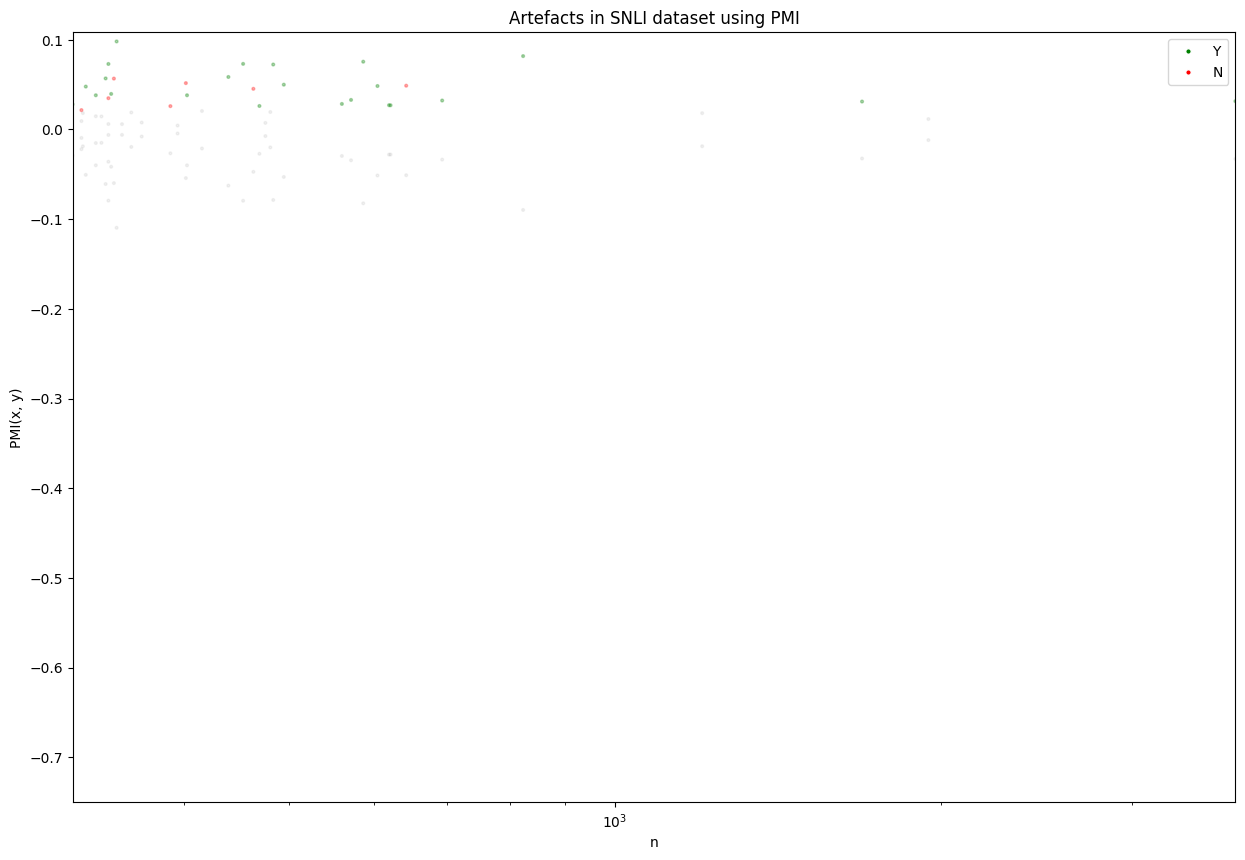

In [31]:
# Define the figure and axes for the plot
fig, ax = plt.subplots(figsize=(15,10))

# Define a dictionary of colors for each label
colors = {'Y': 'g', 'N': 'r', 'grey': 'grey'}

# Define a dictionary of words to annotate in the plot for each label
# token_label_annotate_dict = {
#     'contradiction': ['nobody', 'cats', 'cat', 'no', 'sleeping'],
#     'neutral': ['vacation', 'first', 'competition'],
#     'entailment': ['outdoors', 'animal', 'outside', 'person', 'people']
# }

# Plot the PMI for each token and label
for label in labels:
    # Create a condition series to find which points are above the threshold
    is_above_threshold = smoothed_token_df[f'{label}_pmi'] > pmi_thresholds[label]

    # Create a color and alpha series based on the condition series
    color_series = pd.Series(colors['grey'], index=smoothed_token_df.index)
    color_series[is_above_threshold] = colors[label]

    alpha_series = pd.Series(0.1, index=smoothed_token_df.index)
    alpha_series[is_above_threshold] = 0.3

    # Plot the points for this label
    ax.scatter(smoothed_token_df['total_count'], smoothed_token_df[f'{label}_pmi'], c=color_series, alpha=alpha_series, s=4)

    # Add annotations for selected words
    # for token in set(token_label_annotate_dict[label]) & set(smoothed_token_df['token']):
    #     x = smoothed_token_df.loc[smoothed_token_df['token'] == token, 'total_count'].values[0]
    #     y = smoothed_token_df.loc[smoothed_token_df['token'] == token, f'{label}_pmi'].values[0]
    #     ax.annotate(f'{token} {label[0]}', (x, y))

# Adjust x-axis to be logarithmic and limit its range
ax.set_xscale('log')
ax.set_xlim([10**2.5, max(smoothed_token_df['total_count'])])

ax.set_ylim([-0.75, ax.get_ylim()[1]])

# Hide the first x-axis label
# ax.xaxis.get_major_ticks()[0].label1.set_visible(False)

# Set the labels for the x and y axes, and the title for the plot
ax.set_xlabel('n')
ax.set_ylabel('PMI(x, y)')
ax.set_title('Artefacts in SNLI dataset using PMI')

# Create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=4) for label, color in colors.items() if label != 'grey']
ax.legend(handles=legend_elements, loc='upper right')

# Display the plot
plt.show()


In [33]:
# Create an interactive scatter plot using Plotly

# Define a new figure
fig = go.Figure()

# Define a dictionary of colors for each label
colors = {'Y': 'green', 'N': 'red', 'grey': 'grey'}

# Plot the PMI for each token and label
for label in labels:
    # Get the DataFrame for the current label
    data_label = smoothed_token_df

    # Determine which points are above the threshold
    is_above_threshold = data_label[f'{label}_pmi'] > pmi_thresholds[label]

    # Add scatter plots for points above and below the threshold
    for condition, color in zip([is_above_threshold, ~is_above_threshold], [colors[label], 'grey']):
        token = data_label[condition]['token']
        text = [f"Label: {label}<br>Token: {t}" for t in token]
        fig.add_trace(go.Scatter(
            x = data_label[condition]['total_count'],
            y = data_label[condition][f'{label}_pmi'],
            mode = 'markers',
            name = label if color != 'grey' else None,
            marker = dict(
                color = color,
                size = 4
            ),
            text = text,
            hovertemplate = "%{text}<br>Occurrences: %{x}<br>PMI: %{y}<extra></extra>"
        ))

# Set the scale of the x-axis to logarithmic and limit its range
fig.update_xaxes(type='log', range=[2.5, np.log10(max(token_df['total_count']))])

# Set the labels for the x and y axes, and the title for the plot
fig.update_layout(
    xaxis_title='n',
    yaxis_title='PMI(x, y)',
    title='Artefacts in SNLI dataset'
)

# Display the plot
fig.show()


Analysis of Top N words associated with each label in the NLI data

In [35]:
# Number of top words to display
n_top_words = 10

# For each label, display the top n words by PMI
for label in labels:
    top_words_df = smoothed_token_df.nlargest(n_top_words, f"{label}_pmi")[["token", f"{label}_count"]]
    # percentage of the token that occurs in the sentences of a particular label
    top_words_df[f"{label}_percentage"] = top_words_df[f"{label}_count"] / total_label_counts[label] * 100
    print(f"\nTop {n_top_words} words affiliated with '{label}' by PMI:")
    print(top_words_df.to_string(index=False))


# The top words match with the table 4 presented in the paper but the percentages are different. This might be due to a calculation error?



Top 10 words affiliated with 'Y' by PMI:
   token  Y_count  Y_percentage
    such      192      0.088876
  defect      135      0.062491
      in      448      0.207377
building      161      0.074526
    that      317      0.146738
    with      245      0.113409
      or      184      0.085173
     can      137      0.063417
  person      261      0.120815
    work      136      0.062954

Top 10 words affiliated with 'N' by PMI:
   token  N_count  N_percentage
 rescind      120      0.055898
property      143      0.066612
      do      123      0.057296
     was      161      0.074997
  effect      132      0.061488
    sale      150      0.069873
    real      123      0.057296
  pledge      127      0.059159
  unless      129      0.060091
    even      182      0.084779


# Sentence Length as an Artefact

In [36]:
# coliee_train dataframe contains the hypothesis sentences and the labels
coliee_train.head()

,id,label,premise,hypothesis,tokens
0,H21-1-1,Y,Article 5\n(1) A minor must obtain the consent...,Acceptance made by a minor that received an of...,"[acceptance, made, by, a, minor, that, receive..."
1,H21-1-2,N,Article 6\n(1) A minor who is permitted to con...,"If a minor, after getting permission for carry...","[if, a, minor, after, getting, permission, for..."
2,H21-1-3,Y,Article 9\nA juridical act performed by an adu...,The purchase of daily household items may not ...,"[the, purchase, of, daily, household, items, m..."
3,H21-1-4,N,Article 13\n(1) A person under curatorship mus...,"If a person under curatorship performs, withou...","[if, a, person, under, curatorship, performs, ..."
4,H21-1-5,N,Article 7\nThe family court may decide to comm...,The person in question may not request a comm...,"[the, person, in, question, may, not, request,..."


In [37]:
# create a new dataframe with the hypothesis sentences and the labels
hypothesis_length_df = coliee_train[['hypothesis', 'label']]

In [38]:
hypothesis_length_df

,hypothesis,label
0,Acceptance made by a minor that received an of...,Y
1,"If a minor, after getting permission for carry...",N
2,The purchase of daily household items may not ...,Y
3,"If a person under curatorship performs, withou...",N
4,The person in question may not request a comm...,N
...,...,...
800,A plaintiff shall prove that the opponent has ...,N
801,Parents of a person who died by a tort may cla...,N
802,In cases where an obligee A demands performanc...,N
803,In the cases where delivery of the subject mat...,N


In [39]:
# split the hypothesis sentences into tokens and calculate the length of each sentence again 
# because the preprocessing steps in the paper are not clear

hypothesis_length_df['tokens'] = hypothesis_length_df['hypothesis'].apply(lambda x: x.split())

hypothesis_length_df['length'] = hypothesis_length_df['tokens'].apply(lambda x: len(x))

/var/folders/w5/q2d0spjx14x5z8h5hlljhxfr0000gn/T/ipykernel_9657/1474729126.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/w5/q2d0spjx14x5z8h5hlljhxfr0000gn/T/ipykernel_9657/1474729126.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
hypothesis_length_df

,hypothesis,label,tokens,length
0,Acceptance made by a minor that received an of...,Y,"[Acceptance, made, by, a, minor, that, receive...",24
1,"If a minor, after getting permission for carry...",N,"[If, a, minor,, after, getting, permission, fo...",34
2,The purchase of daily household items may not ...,Y,"[The, purchase, of, daily, household, items, m...",18
3,"If a person under curatorship performs, withou...",N,"[If, a, person, under, curatorship, performs,,...",31
4,The person in question may not request a comm...,N,"[The, person, in, question, may, not, request,...",19
...,...,...,...,...
800,A plaintiff shall prove that the opponent has ...,N,"[A, plaintiff, shall, prove, that, the, oppone...",28
801,Parents of a person who died by a tort may cla...,N,"[Parents, of, a, person, who, died, by, a, tor...",20
802,In cases where an obligee A demands performanc...,N,"[In, cases, where, an, obligee, A, demands, pe...",42
803,In the cases where delivery of the subject mat...,N,"[In, the, cases, where, delivery, of, the, sub...",51


In [41]:
# group the dataframe by the labels
grouped = hypothesis_length_df.groupby("label")

# Initialize a list to hold the length distributions
length_distributions_list = []

for label, group_df in grouped:
    # Calculate the length distribution for this group
    length_distribution = group_df["length"].value_counts(normalize=True).rename("probability").reset_index()
    length_distribution["label"] = label  # Add the label column
    
    # Add this distribution to the list
    length_distributions_list.append(length_distribution)

# Concatenate all the distributions into one DataFrame
length_distributions = pd.concat(length_distributions_list)


In [42]:
length_distributions = length_distributions.sort_values(by=['length'])
length_distributions

,length,probability,label
60,6,0.002519,N
70,6,0.002451,Y
58,7,0.004902,Y
50,7,0.005038,N
61,8,0.002519,N
...,...,...,...
72,107,0.002451,Y
73,109,0.002519,N
71,110,0.002519,N
65,127,0.002451,Y


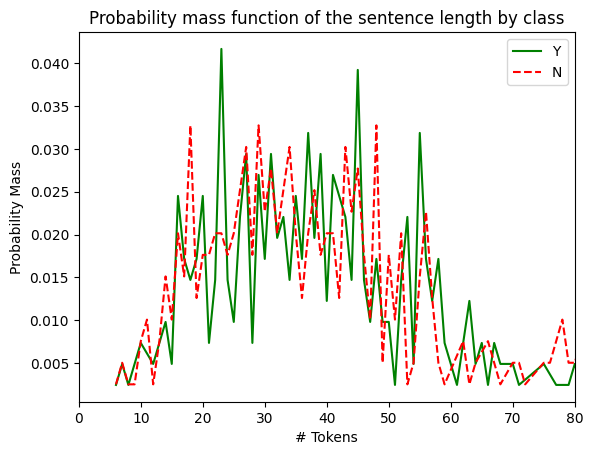

In [47]:
# Initialize the plot
fig, ax = plt.subplots()

# give different line styles to each label
linestyle = {
    "Y": "-",
    "N": "dashed"
}

# provide different colors to each label
colors = {
    "Y": "g",
    "N": "r"
}


# For each label, plot the probability mass function
for label in labels:
    data_label = length_distributions[length_distributions["label"] == label]
    ax.plot(data_label["length"], data_label["probability"], 
            label=label, linestyle=linestyle[label], color=colors[label])

# Set the labels and title for the plot
ax.set_xlabel("# Tokens")
ax.set_ylabel("Probability Mass")
ax.set_title("Probability mass function of the sentence length by class")
ax.legend()

ax.set_xlim([0, 80])

# Display the plot
plt.show()


In [44]:
# calculate the median length of the hypothesis sentences for each label
hypothesis_length_df.groupby('label')['length'].median()

label
N    35.0
Y    38.0
Name: length, dtype: float64

In [45]:
# calculate the mean length of the hypothesis sentences for each label
hypothesis_length_df.groupby('label')['length'].mean()

label
N    38.236776
Y    40.524510
Name: length, dtype: float64